In [194]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [45]:
import pandas as pd
import wandb

api = wandb.Api()

entity = "tunnels-ssl"
project = "01.23"
# Get all runs for the specified project
runs = api.runs(f"{entity}/{project}")


summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict["test/avg_acc_tag"])

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {"avg_acc_tag": summary_list, "config": config_list, "name": name_list}
)
config_df = pd.json_normalize(runs_df["config"])
df = pd.concat([runs_df.drop(columns=["config"]), config_df], axis=1)
df["data.dataset"] = df["data.datasets"].apply(lambda x: x[0])


def get_real_name(row):
    if row["data.exemplars.num_exemplars"] > 0:
        return "replay"
    return row["training.approach.name"]


def is_regularized(row):
    if row["training.vcreg.var_weight"] == 0 and row["training.vcreg.cov_weight"] == 0:
        return False
    return True


df["approach"] = df.apply(get_real_name, axis=1)
df["is_regularized"] = df.apply(is_regularized, axis=1)

In [46]:
df = df[df["training.vcreg.var_weight"] > 0]
filtered_df = df[
    [
        "avg_acc_tag",
        "approach",
        # "training.vcreg.var_weight",
        # "training.vcreg.cov_weight",
        "misc.seed",
        "data.num_tasks",
        "model.network",
        "data.dataset",
        "is_regularized",
    ]
]
filtered_df = filtered_df.rename(
    columns={
        # "test_acc": "avg_acc_tag",
        "data.num_tasks": "num_tasks",
        "data.dataset": "dataset",
        "model.network": "network",
        "misc.seed": "seed",
    }
)

In [47]:
filtered_df

,avg_acc_tag,approach,seed,num_tasks,network,dataset,is_regularized
0,21.45,ewc,1,10,convnext_tiny,cifar100_fixed,True
1,29.68,replay,1,10,convnext_tiny,imagenet_subset_kaggle,True
2,14.10,ewc,1,20,convnext_tiny,cifar100_fixed,True
3,22.08,ewc,0,20,convnext_tiny,imagenet_subset_kaggle,True
4,14.60,ewc,0,20,convnext_tiny,cifar100_fixed,True
5,30.91,ewc,1,5,convnext_tiny,cifar100_fixed,True
6,20.53,ewc,0,10,convnext_tiny,cifar100_fixed,True
7,24.99,replay,2,20,convnext_tiny,cifar100_fixed,True
8,33.24,ewc,1,10,convnext_tiny,imagenet_subset_kaggle,True
9,27.64,replay,0,20,convnext_tiny,imagenet_subset_kaggle,True


In [48]:
from pathlib import Path

import pandas as pd
import numpy as np

# for csv in Path(
#     "/Users/piotr.hondra/Documents/mgr/cl-adaptation/notebooks/csvs_new/resnet34_skips"
# ).rglob("*.csv"):
#     df = pd.read_csv(csv)
#     df["model.network"] = csv.parts[-2]
#     df.to_csv("all.csv", mode="a", header=False)

In [49]:
all_df = pd.read_csv("all.csv")

In [50]:
df_noreg = all_df[all_df["is_regularized"] == False]

In [51]:
pivot_table = pd.pivot_table(
    df_noreg,
    index=["approach", "is_regularized"],
    columns=["dataset", "num_tasks"],
    values="avg_acc_tag",
    aggfunc=lambda x: f"{np.mean(x):.2f}±{np.std(x):.2f}",
    fill_value=0,
)
pivot_table

dataset                   cifar100_fixed                          \
num_tasks                             5           10          20   
approach   is_regularized                                          
ewc        False              26.33±3.26  14.57±2.38   6.89±2.62   
finetuning False              23.38±2.88  13.43±1.90   6.61±1.65   
lwf        False              39.98±0.74  27.64±2.30  20.56±3.11   
replay     False              37.58±3.12  32.00±3.79  28.51±3.28   

dataset                   imagenet_subset_kaggle              
num_tasks                                     10          20  
approach   is_regularized                                     
ewc        False                      17.69±3.99   8.91±1.92  
finetuning False                      14.40±2.89   6.72±0.67  
lwf        False                      39.60±4.20  24.61±5.03  
replay     False                      36.57±2.17  32.39±2.94

In [52]:
filtered_df

,avg_acc_tag,approach,seed,num_tasks,network,dataset,is_regularized
0,21.45,ewc,1,10,convnext_tiny,cifar100_fixed,True
1,29.68,replay,1,10,convnext_tiny,imagenet_subset_kaggle,True
2,14.10,ewc,1,20,convnext_tiny,cifar100_fixed,True
3,22.08,ewc,0,20,convnext_tiny,imagenet_subset_kaggle,True
4,14.60,ewc,0,20,convnext_tiny,cifar100_fixed,True
5,30.91,ewc,1,5,convnext_tiny,cifar100_fixed,True
6,20.53,ewc,0,10,convnext_tiny,cifar100_fixed,True
7,24.99,replay,2,20,convnext_tiny,cifar100_fixed,True
8,33.24,ewc,1,10,convnext_tiny,imagenet_subset_kaggle,True
9,27.64,replay,0,20,convnext_tiny,imagenet_subset_kaggle,True


,num_tasks,approach,is_regularized,avg_acc_tag,dataset,seed,network
0,5,finetuning,False,25.72,cifar100_fixed,1,convnext_tiny
2,5,replay,False,34.70,cifar100_fixed,1,convnext_tiny
4,5,ewc,False,29.55,cifar100_fixed,1,convnext_tiny
6,5,lwf,False,40.63,cifar100_fixed,1,convnext_tiny
8,10,finetuning,False,15.57,cifar100_fixed,1,convnext_tiny
...,...,...,...,...,...,...,...
6,10,lwf,False,36.60,imagenet_subset_kaggle,1,resnet34_skips
8,20,finetuning,False,5.78,imagenet_subset_kaggle,1,resnet34_skips
10,20,replay,False,34.06,imagenet_subset_kaggle,1,resnet34_skips
12,20,ewc,False,7.18,imagenet_subset_kaggle,1,resnet34_skips


In [110]:
merged = pd.concat([df_noreg, filtered_df], axis=0)

In [111]:
pivot_table = pd.pivot_table(
    merged[merged["network"].str.contains("resnet")],
    index=["approach", "is_regularized"],
    columns=["dataset", "num_tasks"],
    values="avg_acc_tag",
    # aggfunc= lambda x: len(x),
    aggfunc=lambda x: f"{np.mean(x):.2f}±{np.std(x):.2f}",
    fill_value=0,
)
pivot_table

dataset                   cifar100_fixed                          \
num_tasks                             5           10          20   
approach   is_regularized                                          
ewc        False              23.10±0.51  12.22±0.11   4.91±2.37   
finetuning False              20.55±0.35  11.54±0.10   5.03±0.61   
lwf        False              39.26±0.24  25.45±0.97  16.89±0.73   
replay     False              40.63±0.89  35.42±2.32  31.60±1.55   

dataset                   imagenet_subset_kaggle              
num_tasks                                     10          20  
approach   is_regularized                                     
ewc        False                      13.73±0.16   7.01±0.12  
finetuning False                      11.52±0.12   6.08±0.24  
lwf        False                      35.47±0.99  19.61±0.38  
replay     False                      38.59±0.72  35.00±1.76

In [179]:
pivot_table = pd.pivot_table(
    merged[merged["network"].str.contains("convnext")],
    index=["approach", "is_regularized"],
    columns=["dataset", "num_tasks"],
    values="avg_acc_tag",
    # aggfunc= lambda x: len(x),
    aggfunc=lambda x: f"{np.mean(x):.2f}±{np.std(x):.2f}",
    fill_value=0,
)
pivot_table

dataset                   cifar100_fixed                          \
num_tasks                             5           10          20   
approach   is_regularized                                          
ewc        False              29.57±0.03  16.92±0.55   8.87±0.53   
           True               31.12±0.16  20.87±0.41  14.36±0.20   
finetuning False              26.21±0.69  15.31±0.37   8.19±0.27   
           True               27.81±0.35  18.18±0.17  12.12±0.19   
lwf        False              40.70±0.09  29.83±0.21  23.01±0.87   
           True               40.88±0.46  30.11±0.45  21.63±0.48   
replay     False              34.53±0.25  28.59±0.13  25.42±0.25   
           True               33.02±0.33  26.28±0.37  24.64±0.25   

dataset                   imagenet_subset_kaggle              
num_tasks                                     10          20  
approach   is_regularized                                     
ewc        False                      21.65±0.70  10.81±0.39  
           True                       33.27±0.16  22.60±0.39  
finetuning False                      17.29±0.30   7.37±0.01  
           True                       26.97±0.82  15.71±0.85  
lwf        False                      43.73±0.46  29.60±0.71  
           True                       43.95±0.89  29.01±0.28  
replay     False                      34.55±0.86  29.78±0.74  
           True                       31.45±1.26  27.25±0.37

In [166]:
convnext_noreg = merged[
    (merged["network"].str.contains("convnext")) & (merged["is_regularized"] == False)
]
convnext_reg = merged[
    (merged["network"].str.contains("convnext")) & (merged["is_regularized"] == True)
]
convnext_noreg_pivot = pd.pivot_table(
    convnext_noreg,
    index=["approach", "seed"],
    columns=["dataset", "num_tasks"],
    values=["avg_acc_tag"],
    # aggfunc= list,
    # aggfunc=list,
    # aggfunc=lambda x: f"{np.mean(x):.2f}±{np.std(x):.2f}",
    fill_value=0,
)
convnext_reg_pivot = pd.pivot_table(
    convnext_reg,
    index=["approach", "seed"],
    columns=["dataset", "num_tasks"],
    values=["avg_acc_tag"],
    # aggfunc= list,
    # aggfunc=list,
    # aggfunc=lambda x: f"{np.mean(x):.2f}±{np.std(x):.2f}",
    fill_value=0,
)

In [181]:
convnext_reg_pivot

avg_acc_tag                                            
dataset         cifar100_fixed               imagenet_subset_kaggle       
num_tasks                   5      10     20                     10     20
approach   seed                                                           
ewc        0             31.28  20.53  14.60                  33.10  22.08
           1             30.91  21.45  14.10                  33.24  22.70
           2             31.18  20.63  14.38                  33.48  23.02
finetuning 0             27.77  18.41  12.07                  27.68  14.98
           1             28.26  17.99  12.37                  27.42  16.90
           2             27.40  18.15  11.92                  25.82  15.26
lwf        0             40.49  29.77  21.05                  44.34  29.32
           1             40.62  29.82  21.63                  42.72  28.64
           2             41.52  30.75  22.22                  44.78  29.06
replay     0             33.18  26.67  24.48                  32.18  27.64
           1             32.56  25.78  24.44                  29.68  27.34
           2             33.32  26.39  24.99                  32.48  26.76

In [182]:
convnext_noreg_pivot

avg_acc_tag                                            
dataset         cifar100_fixed               imagenet_subset_kaggle       
num_tasks                   5      10     20                     10     20
approach   seed                                                           
ewc        0             29.55  16.53   9.25                  21.20  10.26
           1             29.55  16.53   9.25                  21.10  11.14
           2             29.61  17.69   8.12                  22.64  11.04
finetuning 0             25.72  15.57   8.00                  17.38   7.36
           1             25.72  15.57   8.00                  17.60   7.36
           2             27.19  14.79   8.58                  16.88   7.38
lwf        0             40.63  29.98  23.63                  44.38  29.54
           1             40.63  29.98  23.63                  43.44  28.76
           2             40.83  29.54  21.78                  43.36  30.50
replay     0             34.70  28.50  25.24                  34.98  28.74
           1             34.70  28.50  25.24                  33.36  30.44
           2             34.18  28.77  25.78                  35.32  30.16

In [180]:
(convnext_reg_pivot - convnext_noreg_pivot)["avg_acc_tag"]

dataset         cifar100_fixed             imagenet_subset_kaggle       
num_tasks                   5     10    20                     10     20
approach   seed                                                         
ewc        0              1.73  4.00  5.35                  11.90  11.82
           1              1.36  4.92  4.85                  12.14  11.56
           2              1.57  2.94  6.26                  10.84  11.98
finetuning 0              2.05  2.84  4.07                  10.30   7.62
           1              2.54  2.42  4.37                   9.82   9.54
           2              0.21  3.36  3.34                   8.94   7.88
lwf        0             -0.14 -0.21 -2.58                  -0.04  -0.22
           1             -0.01 -0.16 -2.00                  -0.72  -0.12
           2              0.69  1.21  0.44                   1.42  -1.44
replay     0             -1.52 -1.83 -0.76                  -2.80  -1.10
           1             -2.14 -2.72 -0.80                  -3.68  -3.10
           2             -0.86 -2.38 -0.79                  -2.84  -3.40

In [165]:
melted_convnext = (convnext_reg_pivot - convnext_noreg_pivot).melt()
melted_convnext

,index,None,dataset,num_tasks,value
0,0,avg_acc_tag,cifar100_fixed,5,1.73
1,1,avg_acc_tag,cifar100_fixed,5,1.36
2,2,avg_acc_tag,cifar100_fixed,5,1.57
3,3,avg_acc_tag,cifar100_fixed,5,2.05
4,4,avg_acc_tag,cifar100_fixed,5,2.54
5,5,avg_acc_tag,cifar100_fixed,5,0.21
6,6,avg_acc_tag,cifar100_fixed,5,-0.14
7,7,avg_acc_tag,cifar100_fixed,5,-0.01
8,8,avg_acc_tag,cifar100_fixed,5,0.69
9,9,avg_acc_tag,cifar100_fixed,5,-1.52


In [ ]:
warcov = [
    (0.1, 0.1),
    (0.5, 0.25),
    (0.5, 0.5),
    (0.5, 1.0),
]

In [186]:
ratios = [0.5, 1.0, 1.5]

numbers = [0.1, 1, 5, 10, 15, 20]

In [187]:
resutls = []
for number in numbers:
    for ratio in ratios:
        val = number * ratio
        resutls.append((number, val))

In [188]:
resutls

[(0.1, 0.05),
 (0.1, 0.1),
 (0.1, 0.15000000000000002),
 (1, 0.5),
 (1, 1.0),
 (1, 1.5),
 (5, 2.5),
 (5, 5.0),
 (5, 7.5),
 (10, 5.0),
 (10, 10.0),
 (10, 15.0),
 (15, 7.5),
 (15, 15.0),
 (15, 22.5),
 (20, 10.0),
 (20, 20.0),
 (20, 30.0)]

In [ ]:
[
    (0.1, 0.1),
    (0.5, 0.5),
    (1, 0.5),
    (1, 1.0),
    (1, 1.5),
    (5, 2.5),
    (5, 5.0),
    (5, 7.5),
    (10, 5.0),
    (10, 10.0),
    (10, 15.0),
    (15, 7.5),
    (15, 15.0),
    (15, 22.5),
    (20, 10.0),
]

In [ ]:
[
    (0.1, 0.1),
    (0.1, 0.5),
    (0.1, 1.0),
    (0.5, 0.1),
]

In [208]:
arr = [0.1, 0.5, 1, 5, 10, 15, 20]
resutls = []
for i, a in enumerate(arr):
    start = max(0, i - 1)
    end = min(len(arr), i + 2)
    window = arr[start:end]
    for w in window:
        resutls.append((a, w))
    # print(start,end)
    # print(window)
resutls
len(resutls)

[(0.1, 0.1),
 (0.1, 0.5),
 (0.5, 0.1),
 (0.5, 0.5),
 (0.5, 1),
 (1, 0.5),
 (1, 1),
 (1, 5),
 (5, 1),
 (5, 5),
 (5, 10),
 (10, 5),
 (10, 10),
 (10, 15),
 (15, 10),
 (15, 15),
 (15, 20),
 (20, 15),
 (20, 20)]

19

In [220]:
res = []
for var, cov in resutls:
    res.append({"var_weight": var, "cov_weight": cov})
res

[{'var_weight': 0.1, 'cov_weight': 0.1},
 {'var_weight': 0.1, 'cov_weight': 0.5},
 {'var_weight': 0.5, 'cov_weight': 0.1},
 {'var_weight': 0.5, 'cov_weight': 0.5},
 {'var_weight': 0.5, 'cov_weight': 1},
 {'var_weight': 1, 'cov_weight': 0.5},
 {'var_weight': 1, 'cov_weight': 1},
 {'var_weight': 1, 'cov_weight': 5},
 {'var_weight': 5, 'cov_weight': 1},
 {'var_weight': 5, 'cov_weight': 5},
 {'var_weight': 5, 'cov_weight': 10},
 {'var_weight': 10, 'cov_weight': 5},
 {'var_weight': 10, 'cov_weight': 10},
 {'var_weight': 10, 'cov_weight': 15},
 {'var_weight': 15, 'cov_weight': 10},
 {'var_weight': 15, 'cov_weight': 15},
 {'var_weight': 15, 'cov_weight': 20},
 {'var_weight': 20, 'cov_weight': 15},
 {'var_weight': 20, 'cov_weight': 20}]

In [193]:
kwindow

[]

<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Heatmap of Given Points')

Text(0.5, 36.72222222222221, 'X Values')

Text(95.72222222222221, 0.5, 'Y Values')

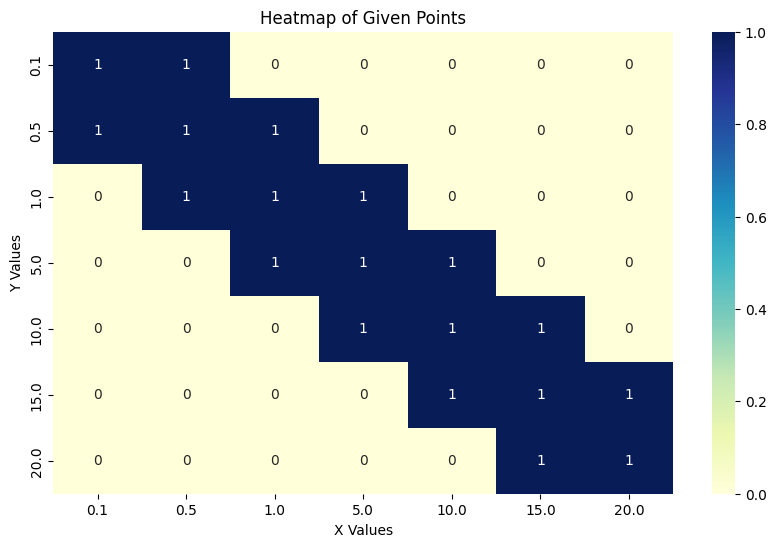

In [209]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Given data points
data_points = [
    (0.1, 0.1),
    (0.1, 0.5),
    (0.5, 0.1),
    (0.5, 0.5),
    (0.5, 1),
    (1, 0.5),
    (1, 1),
    (1, 5),
    (5, 1),
    (5, 5),
    (5, 10),
    (10, 5),
    (10, 10),
    (10, 15),
    (15, 10),
    (15, 15),
    (15, 20),
    (20, 15),
    (20, 20),
]

# Convert to numpy array for easier manipulation
data_array = np.array(data_points)

# Create a grid for the heatmap
x_values = np.unique(data_array[:, 0])
y_values = np.unique(data_array[:, 1])
heatmap_data = np.zeros((len(y_values), len(x_values)))

# Fill the heatmap data with counts of occurrences
for x, y in data_points:
    x_index = np.where(x_values == x)[0][0]
    y_index = np.where(y_values == y)[0][0]
    heatmap_data[y_index, x_index] += 1

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    xticklabels=x_values,
    yticklabels=y_values,
)

plt.title("Heatmap of Given Points")
plt.xlabel("X Values")
plt.ylabel("Y Values")
plt.show()